# Measuring supernova magnitudes

# Overview from previous lectures:
* Opening a fits image
* Finding all objects in the image
* Measuring fluxes and magnitudes of stars
* Make a calibrated light curve

# New objectives for this lecture
* Make a light curve of a supernova 
* Calculate the distance to the supernova 

Data for this lecture should be downloaded from here and "untarred":<br>
https://www.dropbox.com/s/l06w0afjz83974m/NGC3923.tar.gz?dl=0 <br>


Let's start using the magic function we learned last time "%pylab inline".
<br> Then we can import the packeages we will use today: sep, astropy  
<br> From astropy we will import: fits and wcs

In [1]:
%pylab inline
from astropy.io import fits
from astropy import wcs as wcs
import sep
import glob
from astropy.wcs import WCS

Populating the interactive namespace from numpy and matplotlib


# Defining some parameters for our object and getting the files
Here we'll define some useful parameters for our supernova and the standard star, such as the position in the sky (RA/DEC) and magnitude of the standard.

In [2]:
imglist=glob.glob('*fits')
SN_RA = 177.757464 
SN_DEC = -28.743997
STD_RA = 177.7401436
STD_DEC = -28.7764212
std_mag = 15.585 #  16.048

# Opening the first image
Let's open the first image. we will use fits.open to open and put the image in a variable img.
<br> Let's see the image format. Fits mean "Flexible Image Transport System" 
<br> This is a specific format composed by a metadata part and a data part.
The metadata (header) include all the info about the image and the data part is usually a bidimensional array. A fits image can have multiple layers of metadata and data.
<br> For example:<br>
<br> header, data  (level[0])
<br> header, data  (level[1])
<br> header, data  (level[2])
<br> You can see how many layers your image has using the function len()

In [3]:
#print(imglist)
hdu= fits.open(imglist[0])
header = hdu[0].header
img = hdu[0].data
#print(header)

# Review of WCS and plotting an image
* There is no "up" in space so we use RA/Dec to define where things are in reference.
* Use w.wcs_world2pix(object_RA, object_DEC, 1) for each object we're interested in to get the pixel coordinates in the image. The 3rd arguement defines the "origin", which should be 1 for fits images.
* Remember that we already defined the RA and Dec of two objects, the supernova and the standard star.
* Plot the image using plt.imshow as in previous lectures. Recall using a histogram find good values of "vmin" and "vmax" for the display.

(150.0, 700.0)

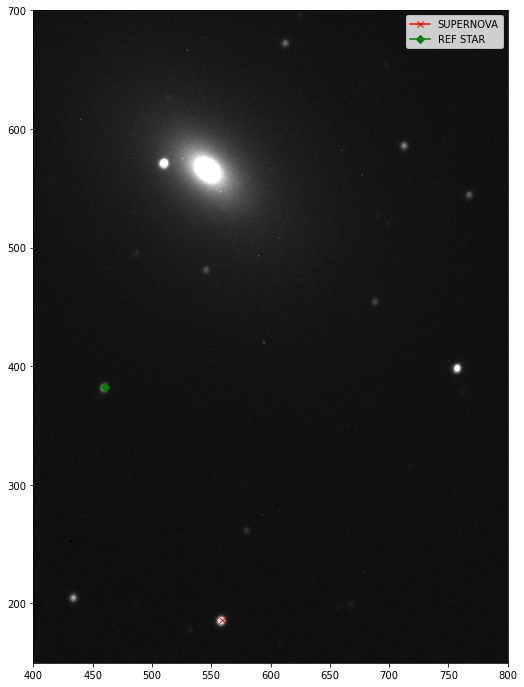

In [4]:
w = WCS(header)

# Transform star coordinates to image pixels:
sn_px, sn_py = w.wcs_world2pix(SN_RA,SN_DEC, 1)
std_px, std_py = w.wcs_world2pix(STD_RA,STD_DEC, 1)

# Plot the image. We'll set vmin=50 and vmax=1800 to scale the image display,
# but recall using histograms to find good values for these parameteres
plt.figure(figsize=(10,12))
imgshow = plt.imshow(img, origin='lower', cmap='gray', vmin=50, vmax=1800)

# Add each star to the plot with a label, then add a legend.
plt.plot(sn_px, sn_py, marker='x', color='r', label = 'SUPERNOVA')
plt.plot(std_px, std_py, marker='D', color='g', label = 'REF STAR')
plt.legend()

# Let's zoom in to the region around the supernova and galaxy 
plt.xlim(400,800)
plt.ylim(150,700)

Now we would like to be able to find the position of all stars in the image. But in order to do that with the package sep, we need to define the background of the image. 
Sep has a command for that: sep.Background(X). 
But before doing that there is a command to run: X = X.byteswap().newbyteorder() then we can subtract the background

In [5]:
# Let's define some lists that we can use to store the data for each object and the zero point of the image
flux_vec =[]
flux_std_vec=[]
fluxerr_vec =[]
jd_vec = []
ZP_vec = []

# Now for each image we're going to do what we did last lecture and extract the information we care about
for img in imglist:
    hdu= fits.open(img)
    header = hdu[0].header
    X = hdu[0].data
    X = X.byteswap().newbyteorder()
    bkg = sep.Background(X)
    data_sub = X - bkg
    
    # Store the wcs for this image as 'w', and get the image pixel coordinates
    # for our supernova and the standard star
    w = WCS(header)
    sn_px, sn_py = w.wcs_world2pix(SN_RA,SN_DEC, 1)
    std_px, std_py = w.wcs_world2pix(STD_RA,STD_DEC, 1)
    
    # Background subtract the image data and extract the sources
    objects = sep.extract(data_sub, thresh=3.0, err=bkg.globalrms, mask=None, \
                          minarea=10, clean=True, filter_type = 'matched',\
                          clean_param=1.0, segmentation_map=False)
    
    # Finally, we’ll perform simple circular aperture photometry with 
    # a 3 pixel radius at the locations of the objects:
    flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'],
                                     5.0, err=bkg.globalrms, gain=1.0)
    
    # Let's loop over the stars and find the nearest to our supernova and the standard star
    # We will use a distance cutoff of 15 pixels
    sn=False
    std=False
    for i,j in enumerate(objects['x']):
        if (objects['x'][i]-sn_px)**2+(objects['y'][i]-sn_py)**2 <15:
            sn=i
        if (objects['x'][i]-std_px)**2+(objects['y'][i]- std_py)**2 < 15:
            std=i
        # If we detect a source close to both the standard and the supernova we save them
        if std is not False and sn is not False:
                flux_vec.append(flux[sn])
                flux_std_vec.append(flux[std])
                fluxerr_vec.append(fluxerr[sn])
                jd_vec.append(header['jd'])
                ZP_vec.append(header['ZP'])
                
                # Once we find both objects in the image we end the loop
                break
    if std is False or sn is False:
        print(img,' this image is missing the sn or the standard')        

NGC3923_2018-04-04.51.fits  this image is missing the sn or the standard
NGC3923_2018-04-05.61.fits  this image is missing the sn or the standard
NGC3923_2018-04-29.06.fits  this image is missing the sn or the standard
NGC3923_2018-04-09.6.fits  this image is missing the sn or the standard
NGC3923_2018-04-02.52.fits  this image is missing the sn or the standard
NGC3923_2018-06-07.16.fits  this image is missing the sn or the standard
NGC3923_2018-04-09.56.fits  this image is missing the sn or the standard
NGC3923_2018-05-13.03.fits  this image is missing the sn or the standard
NGC3923_2018-05-03.25.fits  this image is missing the sn or the standard


# Quick reminder about the magnitude system
* For each image we just extracted the flux, now we need to convert that into the magnitude
* Conversion is done with the equation:
<img src="https://latex.codecogs.com/svg.latex?\space m=-2.5\times log_{10}(f)"/>
where f is our flux we just measured
* Remember that in the magnitude system smaller numbers are brighter objects
* Finally, we'll plot the magnitude over time, or "light curve".

the zero point of the first image image is  26.907889787712982
The peak magnitude is  12.988742743928931


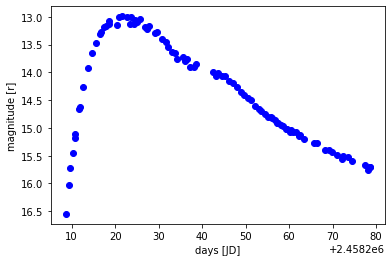

In [6]:
# Transform the flux in magnitude for the SN and the std
mag_vec = -2.5 * np.log10(flux_vec)
magerr_vec = -2.5 * np.log10(np.array(flux_vec) + np.array(fluxerr_vec)) + 2.5 * np.log10(flux_vec)
magstd_vec = -2.5 * np.log10(flux_std_vec)

# Compute the zeropoint from the standard 
# We know what the magnitude should be
# The zeropoint is an offset to match the known magnitude of the standard
ZP_new = std_mag - magstd_vec

print('the zero point of the first image image is ',ZP_new[0])

# Plot the light curve
plt.plot(jd_vec,ZP_new+mag_vec,'ob')

plt.xlabel('days [JD]')
plt.ylabel('magnitude [r]')
plt.gca().invert_yaxis()
maximum = min(ZP_new+mag_vec)
print('The peak magnitude is ',str(maximum))

# Brightness-decline relation
* How quickly a Type Ia supernova declines is related to its brightness
* Discovered in the 1970s and formalized in the 1990s
* The absolute magnitude is related to the decline by:
<img src="https://latex.codecogs.com/svg.latex?\space M_{max}=-21.726+2.698\times\Delta m_{15}"/>

In [7]:
# Dust is everywhere in the universe and causes objects to appear fainter.
# We have to correct for that!
corrected_max = maximum - 0.228
print('Maximum magnitude:',corrected_max)

# Now let's apply the brightness-decline relation to get the absolute magnitude
# We will assume that the dm15 of this supernova is 1
dm15 = 1
absolute_mag = -21.726 + 2.698*dm15

# Finally, we can easily compute the distance to the supernova using the distance modulus
mu =  corrected_max - absolute_mag
print('Distance modulus:',mu)
d= 10**((mu/5.)+1)
print('Distance in parsecs:',d/1e6)

Maximum magnitude: 12.760742743928931
Distance modulus: 31.78874274392893
Distance in parsecs: 22.790221638633145
